# Paired GAN

Training with a list of paired samples (source, target) input.

Ref: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson7-superres-gan.ipynb

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

In [2]:
ls

 BERT.ipynb                 GANs.ipynb               'segmentation demo.ipynb'
 Callbacks.ipynb           'Test some losses.ipynb'   tabular.ipynb
'GANs - unfinished.ipynb'   gandata/


In [4]:
path = Path("./gandata")
path_gray = path/"gray"
path_color = path/"color"


In [6]:
bs, size = 32, 128

# #Pre-train generator

In [7]:

arch = models.resnet34
src = ImageImageList.from_folder(path_gray).split_by_rand_pct(0.1, seed=42)

In [10]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_color/x.name)
           .transform(get_transforms(max_zoom=1.5), size=size, tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats, do_y=True)
           )
    data.c = 3
    return data


In [11]:
data_gen = get_data(bs, size)

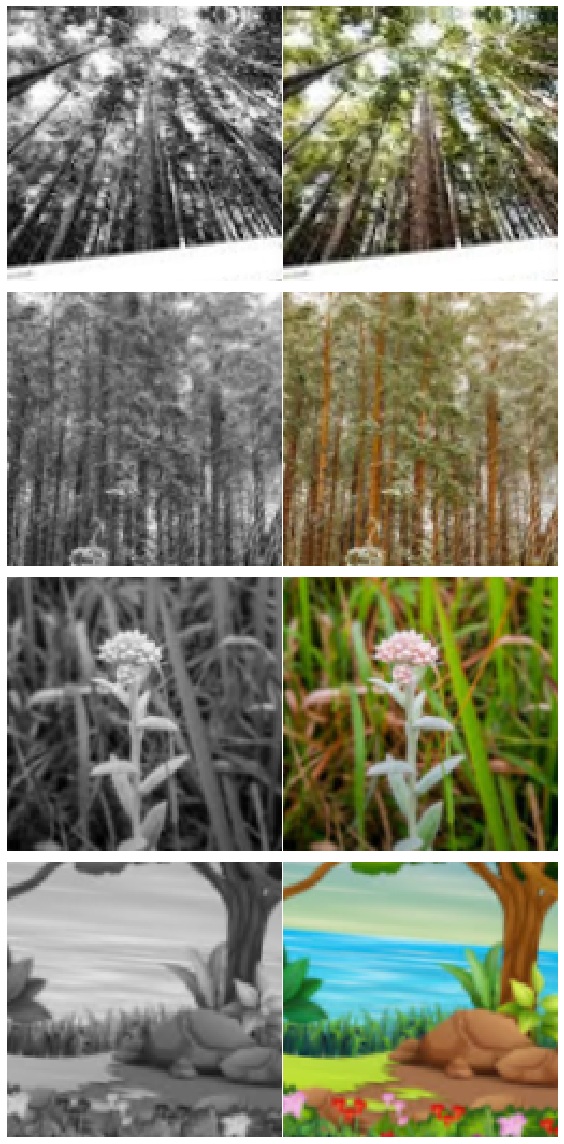

In [12]:
data_gen.show_batch(4)

In [13]:
wd = 1e-3

In [62]:
# y_range=(-1., 1.) #what for?

In [61]:
unet_learner??

In [74]:
loss_gen = MSELossFlat()

def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, norm_type=NormType.Weight, self_attention=True,
#                         y_range=y_range,
                       loss_func=loss_gen)


In [75]:
learn_gen = create_gen_learner()

In [76]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,1.674018,0.453506,00:01
1,1.143275,0.376461,00:01


In [77]:
learn_gen.unfreeze()
learn_gen.fit_one_cycle(5, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,0.409846,0.304073,00:01
1,0.360463,0.310879,00:01
2,0.328208,0.260833,00:01
3,0.311107,0.265764,00:01
4,0.295778,0.262795,00:01


In [78]:
learn_gen.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,time
0,0.235966,0.254241,00:01
1,0.233877,0.252150,00:01
2,0.228268,0.236556,00:01
3,0.232269,0.240344,00:01
4,0.233491,0.241831,00:01


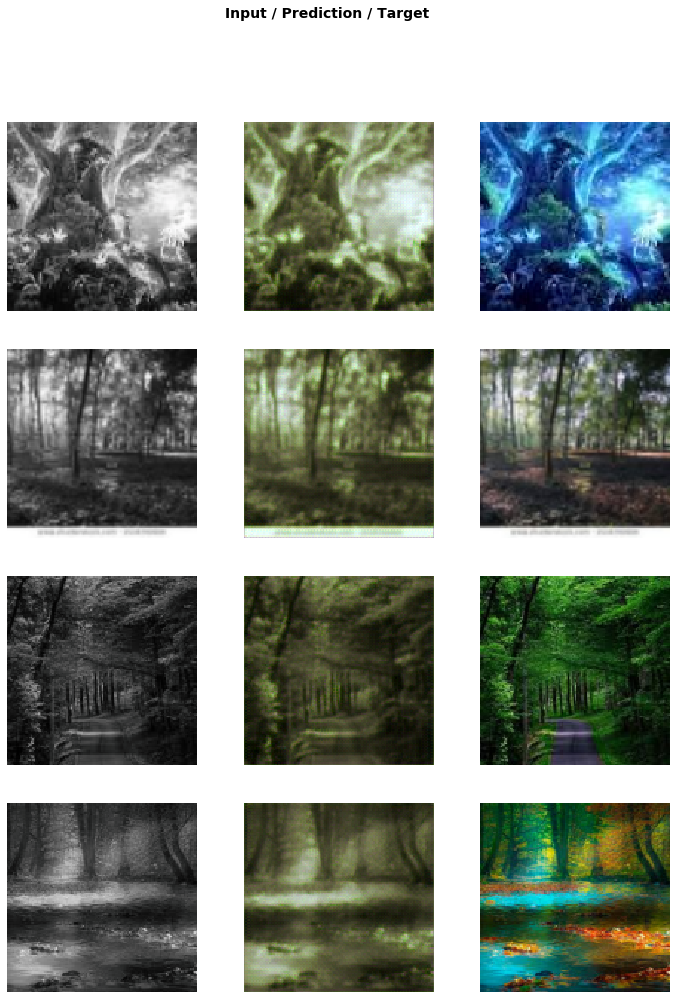

In [79]:
learn_gen.show_results(rows=4)

# save generated images


In [31]:
path_gen = path/"image_gen"

In [32]:
path_gen.mkdir(exist_ok=True)

In [33]:
def save_preds(dl):
    i = 0
    names = dl.dataset.items
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
        

In [34]:
save_preds(data_gen.fix_dl)

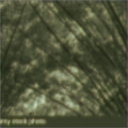

In [35]:
PIL.Image.open(path_gen.ls()[0])

# Train critic

In [ ]:
# #if need memory
# learn_gen = None
# gc.collect()

In [36]:
def get_critic_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=1.5), size=size)
           .databunch(bs=bs)
           .normalize(imagenet_stats)
           )
    data.c = 3
    return data


In [39]:
data_crit = get_critic_data(['image_gen', 'color'], bs=bs, size=size)

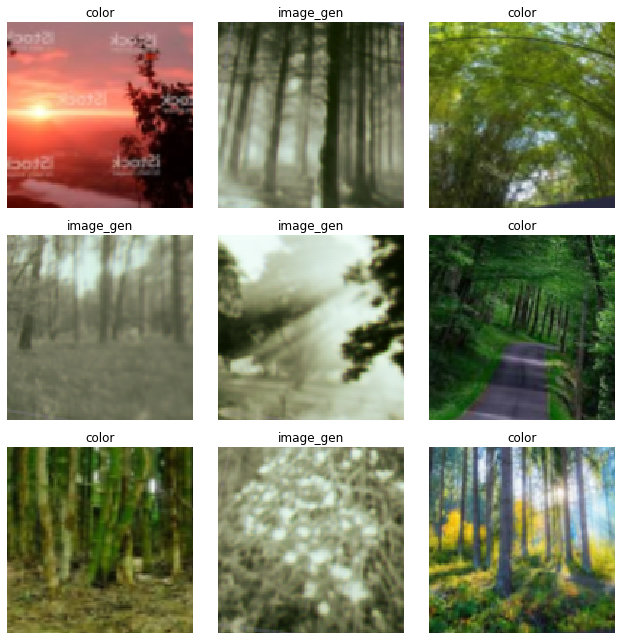

In [40]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [83]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [84]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [85]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [86]:
learn_critic.fit_one_cycle(6, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.362134,0.000001,1.000000,00:01
1,0.175585,0.000000,1.000000,00:01
2,0.113476,0.000000,1.000000,00:01
3,0.082478,0.000000,1.000000,00:01
4,0.063925,0.000000,1.000000,00:01
5,0.051594,0.000000,1.000000,00:01


# save models

In [87]:
learn_gen.save('gen-pre2')
learn_critic.save('critic-pre2')


# Train a GAN model

We'll combine those two pretrained model in a GAN.

To define a GAN learner, we just have to specify the learner objects for the generator and the critic.
The switcher is a callback that decides when to switch from discriminator to generator and vice versa.
--> Here we do as many iterations of the discriminator as needed to its loss back < 0.6 then one iteration of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions (target 1) and the batch of fake predictions (target 0).

The loss of the generator is weighted sum (weights in `weights_gen`) of `learn_crit.loss_func` on the batch of fake (passed through the critic to become predictions) with a target of 1, and the `learn_gen.loss_func` applied to the output (batch of fake) and the target (corresponding batch of color images).

In [88]:
#If need memory
learn_critic = None
learn_gen = None
gc.collect()

79726

In [89]:
data_crit = get_critic_data(['image-gen', 'color'], bs=bs, size=size)
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')
learn_gen = create_gen_learner().load('gen-pre2')

In [90]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.7)
learn = GANLearner.from_learners(learn_gen, learn_crit,
                                weights_gen=(1., 20.),
                                show_img=False,
                                switcher=switcher,
                                opt_func=partial(optim.Adam, betas=(0., 0.99)),
                                wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [91]:
lr = 1e-4

In [92]:
learn.fit(40, lr)

In [58]:
learn.save('gan-1c')

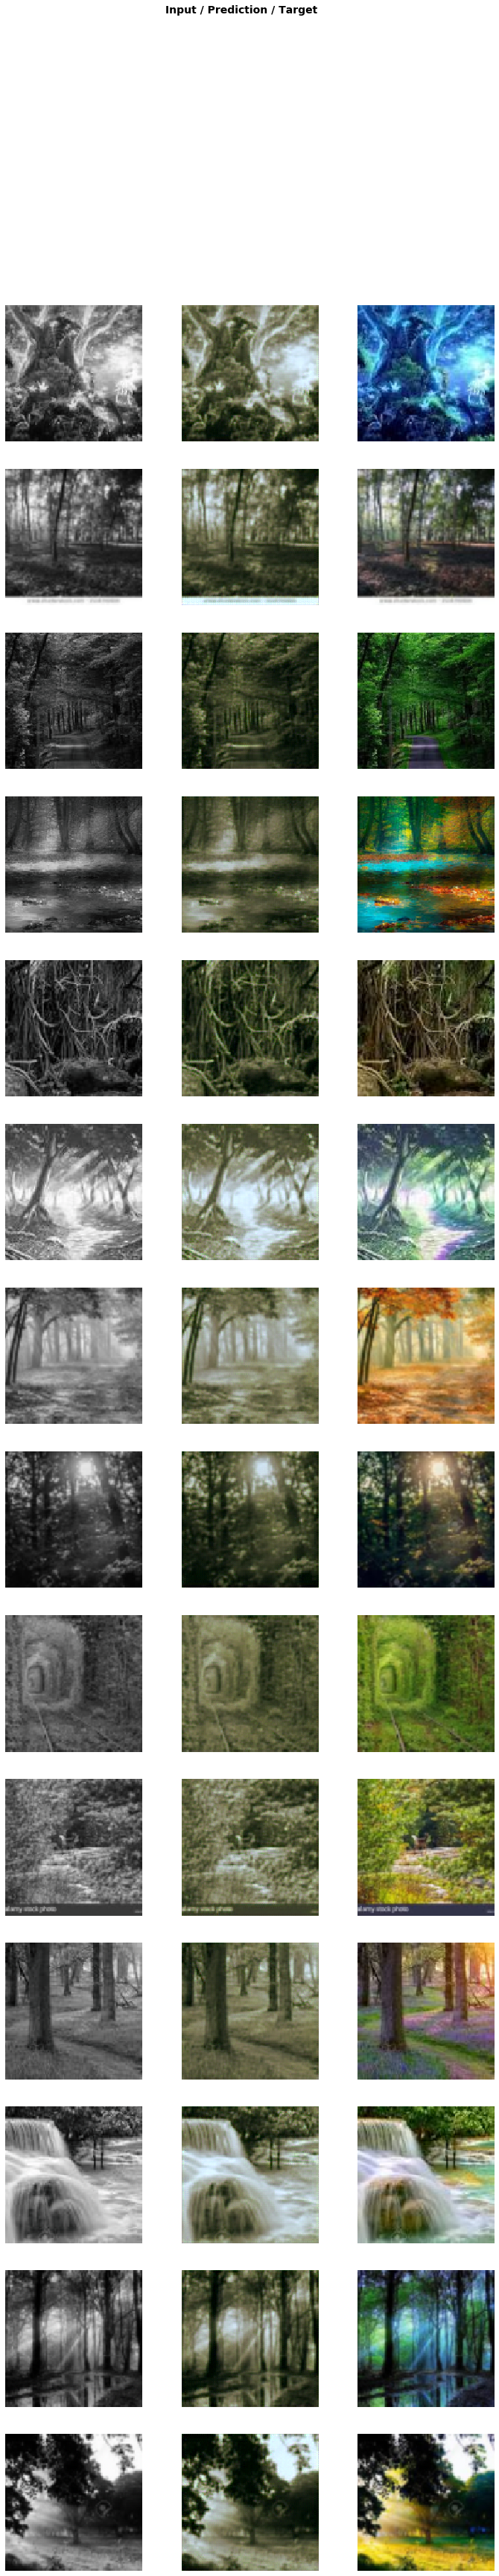

In [93]:
learn.show_results(rows=14)

In [94]:
from torch import nn

In [95]:
conv = nn.Conv2d(
    in_channels=100,
    out_channels=5,
    kernel_size=3,
    stride=1,
    padding=1,
    groups=1
)
print(conv.weight.shape)

torch.Size([5, 100, 3, 3])


In [97]:
conv = nn.Conv2d(
    in_channels=100,
    out_channels=5,
    kernel_size=3,
    stride=1,
    padding=1,
    groups=5
)
print(conv.weight.shape)

torch.Size([5, 20, 3, 3])
